Approach1 Exponential Coeff: [ 2.36060057 -0.02492932]
Approach1 Exponential Coeff: [0.0030879 0.5574533]
Approach1 Exponential Coeff: [130.19597934   0.42614584]
CLM exp. params:[0.00330571 0.55610661]


/var/folders/m6/wvphmt5n66n52rl8rv8xrfr80000gp/T/ipykernel_90186/102895166.py:150: UserWarning: The following kwargs were not used by contour: 'color'
  contour = plt.contour(10**xi, 10**yi, zi, levels=32, color='red')


Approach1 Exponential Coeff: [ 2.12612386 -0.02872987]
Approach1 Exponential Coeff: [1.36463562e-07 7.59801868e-01]
Approach1 Exponential Coeff: [6.14903758e+05 2.56133566e-01]
MLM exp. params:[1.36463562e-07 7.59801868e-01]


/var/folders/m6/wvphmt5n66n52rl8rv8xrfr80000gp/T/ipykernel_90186/102895166.py:150: UserWarning: The following kwargs were not used by contour: 'color'
  contour = plt.contour(10**xi, 10**yi, zi, levels=32, color='red')


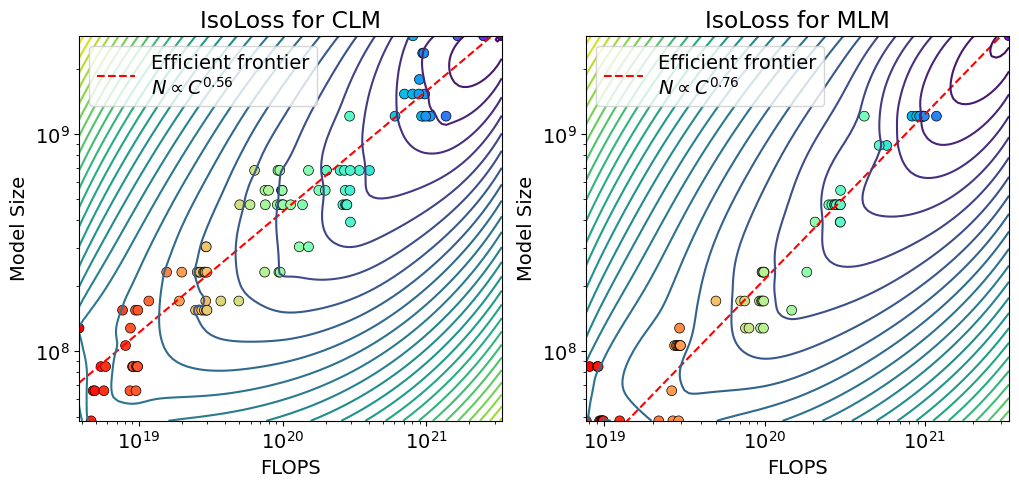

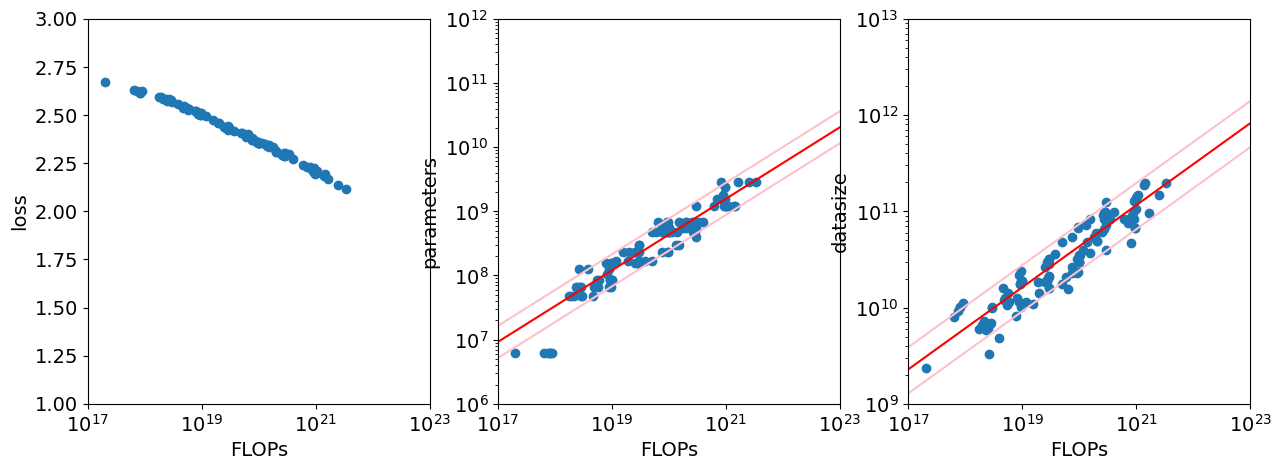

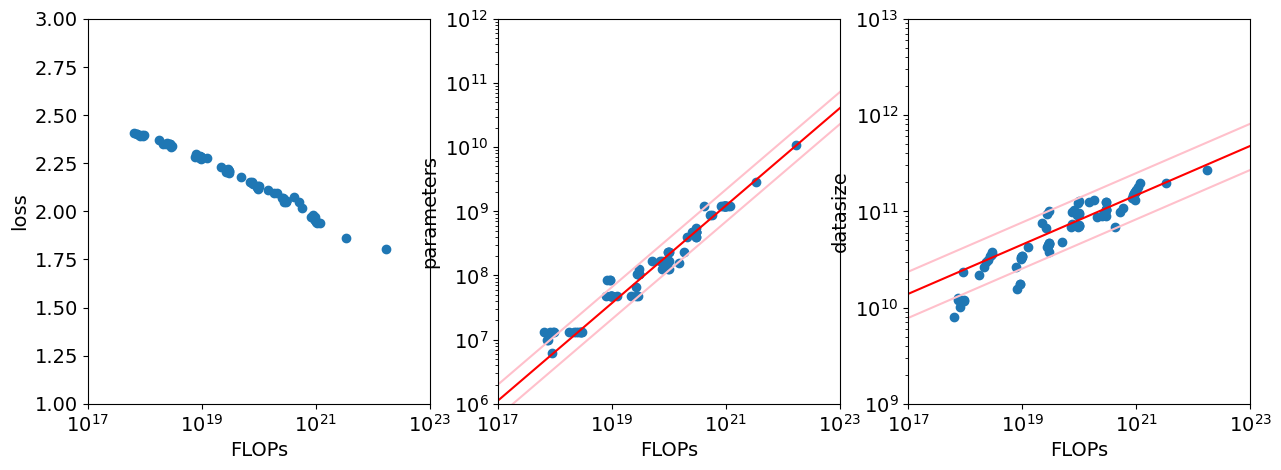

In [3]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import FuncFormatter
from scipy.optimize import curve_fit
from collections import defaultdict
from scipy.optimize import minimize
import matplotlib as mpl
import pickle
plt.rcParams.update({'font.size': 14})
def min_loss_by_flops(data):
    # Using dictionary comprehension and the min function
    return {flops: min(d[flops] for d in data.values() if flops in d) for flops in set().union(*data.values())}

def format_exponential(x, pos):
    """Custom formatting function, convert scale to 10^x form"""
    if x <= 0:
        return "N/A"
    exponent = int(np.log10(x))
    return f'$10^{exponent}$'

def linear_fit(x, a, b):
    return a * x + b

def chinchilla_fit(N_and_D, E, A, B, alpha, beta):
    N, D = N_and_D
    return E + A / (N ** alpha) + B / (D ** beta)

def exponential_fit(x, a, b):
    return a * np.power(x, b)
def exponential_inverse_fit(x, a, b):
    return np.power(a/x ,b)

def fit_inverse_exp_curve(x, y, is_ND=True):
    pfs = 8.64e+19
    if is_ND:
        params, covariance = curve_fit(exponential_fit, 1.0/np.array(x), y, maxfev=100000)
    else:
        params, covariance = curve_fit(exponential_fit, 1.0/(np.array(x)/pfs), y, maxfev=100000)
    return params

def fit_exp_curve(x, y, is_ND=True):
    pfs = 8.64e+19
    if is_ND:
        params, covariance = curve_fit(exponential_fit, np.array(x), y, maxfev=10000)
    else:
        params, covariance = curve_fit(exponential_fit, np.array(x)/pfs, y, maxfev=10000)
    return params 

def fit_chinchilla_curve(N, D, L_hat, p0):
    N_and_D = (N,D)
    params, cov = curve_fit(chinchilla_fit, N_and_D, L_hat, p0, maxfev=12000, method='trf')
    return params

def fit_data(d1, d2, d3, points=500):


    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    dicts = [d1, d2, d3]
    y_labels = ['loss', 'parameters', 'datasize']
    preds = dict()
    for i, d in enumerate(dicts):
        axs[i].scatter(d.keys(), d.values())

        x = list(d.keys())
        y = list(d.values())
        x_ext = np.power(10, np.linspace(np.log10(1e17),np.log10(1e24), points))


        exp_params = fit_exp_curve(x,y, i)
        exp_fitted_y = exponential_fit(x_ext, *exp_params)
        print(f'Approach1 Exponential Coeff: {exp_params}')

        if i == 0:
            #axs[i].plot(x_ext, linear_fitted_y, color='red')
            axs[i].plot(x_ext, exp_fitted_y, color='red')
        elif i == 1:
            axs[i].plot(x_ext, exp_fitted_y, color='red')
            delta = 0.25
            up_fitted_y = np.power(10, (np.log10(exp_fitted_y)  +  delta))
            down_fitted_y = np.power(10, (np.log10(exp_fitted_y)  -  delta))
            axs[i].plot(x_ext, up_fitted_y, color='pink')
            axs[i].plot(x_ext, down_fitted_y, color='pink')
        elif i == 2:
            axs[i].plot(x_ext, exp_fitted_y, color='red') 
            delta = 0.25
            up_fitted_y = np.power(10, (np.log10(exp_fitted_y)  +  delta-0.02))
            down_fitted_y = np.power(10, (np.log10(exp_fitted_y)  -  delta))
            axs[i].plot(x_ext, up_fitted_y, color='pink')
            axs[i].plot(x_ext, down_fitted_y, color='pink')
         


        axs[i].set_xlabel('FLOPs')
        axs[i].set_ylabel(y_labels[i])
        axs[i].set_xlim(1e17, 1e23)
        axs[i].xaxis.set_major_formatter(FuncFormatter(format_exponential))
        axs[i].set_xscale('log')

        if i == 0:
            axs[i].set_ylim(1, 3) 
        elif i == 1:
            axs[i].set_ylim(1e6, 1e12)
            axs[i].set_yscale('log')
        elif i == 2:
            axs[i].set_ylim(1e9, 1e13)
            axs[i].set_yscale('log')

 

def plot_contour(loss, modelsize, plt, obj=0):
    from scipy.interpolate import  Rbf
    loss = {k: v for k, v in loss.items() if k >= 3e18 and k <=1e22 }
    modelsize = {k: modelsize[k] for k in loss.keys()}
 
    x = np.log10(np.array(list(loss.keys())))
    y = np.log10(np.array(list(modelsize.values())))
    z = np.array(list(loss.values()))

    if obj == 0:
        with open('../law_weights/CLM_app3_law.pkl', 'rb') as f:
            # parametric fit by the provided data (training log) 
            exp_params = pickle.load(f) 
            print(f"CLM exp. params:{exp_params}")
            x_ext = np.linspace(x.min(), x.max(), 100)
            exp_fitted_y = exponential_fit(10**x_ext, *exp_params)
            plt.plot(10**x_ext, exp_fitted_y, color='red', linestyle='--', label='Efficient frontier\n$N \propto C^{0.56}$')
    if obj == 1:
        with open('../law_weights/MLM_app3_law.pkl', 'rb') as f:
            # parametric fit by the provided data (training log)
            exp_params = pickle.load(f)
            print(f"MLM exp. params:{exp_params}")
            x_ext = np.linspace(x.min(), x.max(), 100)
            exp_fitted_y = exponential_fit(10**x_ext, *exp_params)
            plt.plot(10**x_ext, exp_fitted_y, color='red', linestyle='--', label='Efficient frontier\n$N \propto C^{0.76}$')


    xi = np.linspace(x.min(), x.max(), 100)
    yi = np.linspace(y.min(), y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)

    rbfi = Rbf(x, y, z, function='linear')  
    zi = rbfi(xi, yi)
    vmin = z.min()
    vmax = z.max()
    contour = plt.contour(10**xi, 10**yi, zi, levels=32, color='red')
    plt.scatter(10**x[:-1], 10**y[:-1], c=z[:-1], s=50, cmap='rainbow', edgecolors='k', linewidths=0.5)
    if obj == 0:
        plt.set_title('IsoLoss for CLM')
    else:
        plt.set_title('IsoLoss for MLM')
    plt.set_xlabel('FLOPS')
    plt.set_ylim(10**y.min(), 10**y.max())
    plt.legend()
    plt.set_xscale('log')
    plt.set_yscale('log')
    plt.set_ylabel('Model Size')



def find_minimum_value(data_dir, gflops_range=(1e9, 1e14), points=200):
    flops_modelsize = dict()
    flops_minloss = dict()
    flops_closest = dict()
    flops_datasize = dict()

    flops_modelsizelist = dict()
    flops_losslist = dict()
    flops_closestlist = dict()
    flops_datasizelist = dict()

    model_size_map = {'3M':3538944,'6M':6291456,'10M':9830400 ,'13M':13192320,'20M':19267584,'25M': 25165824, '34M':33690624, '40M':39813120, '47M':47775744, '65M':65728000, '85M':84934656, '106M':106168320, '127M':127699968 ,'154M': 154448288, '170M':170233344, '200M':202309632, '230M': 231211008, '300M':302426080, '393M':393216000,  '470M':472435184, '550M': 550502400, '650M':650930624, '680M':680205312,'880M':886308864, \
    '1.2B':1208881136, '1.5B':1528823808,  '1.7B':1784851968, '2B':2044723200, '2.4B':2359296000,   '2.8B': 2834283904, '3.4B':3425697792, '4B':4076863488, '5B':4917322640, '6B':6165626880, '7B':7247758312, '10B':10682105856}


    target_flops_list = []
    
    for subdir in os.listdir(data_dir):
        if os.path.isdir(os.path.join(data_dir, subdir)):
            for file in os.listdir(os.path.join(data_dir, subdir)):
                file_path = os.path.join(data_dir, subdir, file)
                if not file.startswith("run"):
                    continue
                # Assuming the file is in a format readable by pandas
                data = pd.read_csv(file_path, skiprows=2, header=None, names=['WallTime', 'FLOPs', 'Loss'], encoding='latin1')
                target_flops_list.extend([min(data['FLOPs'].values.tolist()[-10:])])
    target_flops_list = sorted(target_flops_list)

    # Iterate over each subdirectory in the data directory
    for subdir in os.listdir(data_dir):
        if os.path.isdir(os.path.join(data_dir, subdir)):

            # Extract model size from the directory name
            model_size_str = subdir.split('_')[0]
            if model_size_str in model_size_map:
                model_size = model_size_map[model_size_str]
                #print(model_size)
            else:
                continue

            # bsz X seqlen X eval interval
            if model_size_str[-1] == 'B':
                data_interval = 1024 * 1024 * 300 
            else:
                data_interval = 512 * 1024 * 300

            # Initialize a variable to store the minimum value for this model size
            min_value_for_model = float('inf')
            closest_flops_for_model = None

            #Initilize important value for seperated model size, for approach 2
            flops_losslist.setdefault(model_size,dict())
            flops_modelsizelist.setdefault(model_size,dict())
            flops_datasizelist.setdefault(model_size,dict())
            flops_closestlist.setdefault(model_size,dict())

            # Read all files in the subdirectory
            for file in os.listdir(os.path.join(data_dir, subdir)):
                file_path = os.path.join(data_dir, subdir, file)
                if not file.startswith("run"):
                    continue
                # Assuming the file is in a format readable by pandas
                data = pd.read_csv(file_path, skiprows=2, header=None, names=['WallTime', 'FLOPs', 'Loss'], encoding='latin1')

                # Iterate over the specified FLOPs range
                #for target_flops in np.power(10, np.linspace(np.log10(gflops_range[0]), np.log10(gflops_range[1]), num=points)): #Approach1
                #for target_flops in np.linspace(gflops_range[0], gflops_range[1], num=points): #Approach3
                for target_flops in target_flops_list: #Approach3
                    
                    # Find the row with the closest FLOPs value, if the closest FLOPs diff larger than 1e8, then filt it.
                    flops_diff = (data['FLOPs'] - target_flops).abs()
                    if flops_diff.min() > 1e9:
                        continue
                    # Convert the GFLOPs to FLOPs 
                    target_flops = target_flops * 1e9 
                    
                    # Find the minimum  datasize and loss for this FLOPs value
                    eval_runs_idx = data.iloc[flops_diff.argsort()[:1]].index.values[0] + 1
                    closest_flops_frame = data.iloc[flops_diff.argsort()[:1]]
                    min_value = closest_flops_frame['Loss'].values[0]


                    if flops_minloss.get(target_flops) is None or flops_minloss[target_flops] > min_value:
                        flops_minloss[target_flops] = min_value
                        flops_modelsize[target_flops] = model_size
                        flops_closest[target_flops] = closest_flops_frame['FLOPs'].values[0]
                        flops_datasize[target_flops] = eval_runs_idx * data_interval

                    # according for model size, the min_value is the only one exact loss for this model size.
                    if flops_losslist[model_size].get(target_flops) is None or flops_losslist[model_size][target_flops] > min_value:
                        flops_losslist[model_size][target_flops] = min_value



    # Find the model size with the overall minimum value
    return flops_minloss, flops_modelsize, flops_datasize, flops_losslist


data_directories = ["../data/training_logs/gpt_valid/approach3_flops" , "../data/training_logs/mlm_valid/approach3_flops"]
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Creates a figure with two subplots side by side

for idx, data_directory in enumerate(data_directories):
    flops_minloss, flops_modelsize, flops_datasize, flops_losslist = find_minimum_value(data_directory)
    fit_data(flops_minloss, flops_modelsize, flops_datasize)
    plot_contour(flops_minloss, flops_modelsize,  axs[idx], idx)
plt.show()